<center> <h1> Clustering using Variational Autoencoder</h1> </center>

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')

In [2]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from VAE_architecture import VAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)

## I. MNIST

In [3]:
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


## I.1 Latent_dim = 16

In [4]:
autoencoder_vae=VAE(latent_dim=16)
autoencoder_vae.load_state_dict(torch.load('./VAE_models/VAE_MNIST_zdim_16_epochs_15.pth'))

<All keys matched successfully>

Clustering using GaussianMixture

In [5]:
z_test = autoencoder_vae.encode(X_test)
z_train = autoencoder_vae.encode(X_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

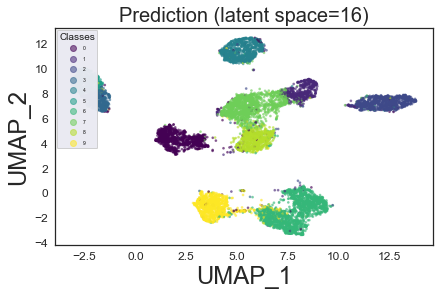

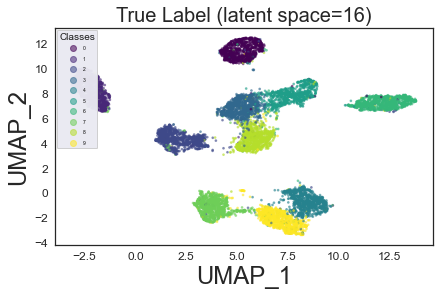

In [6]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="MNIST")

<Figure size 432x288 with 0 Axes>

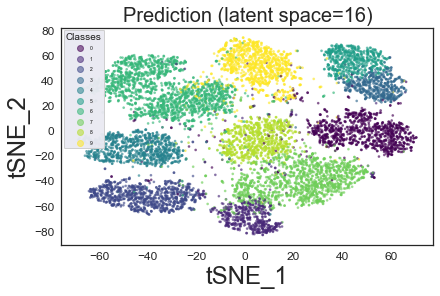

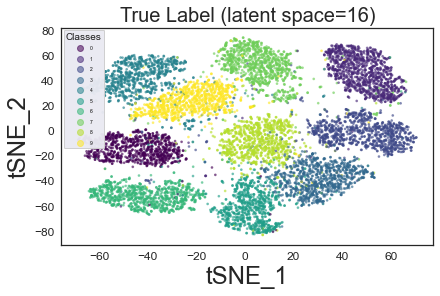

In [7]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="MNIST")

Samples of each cluster

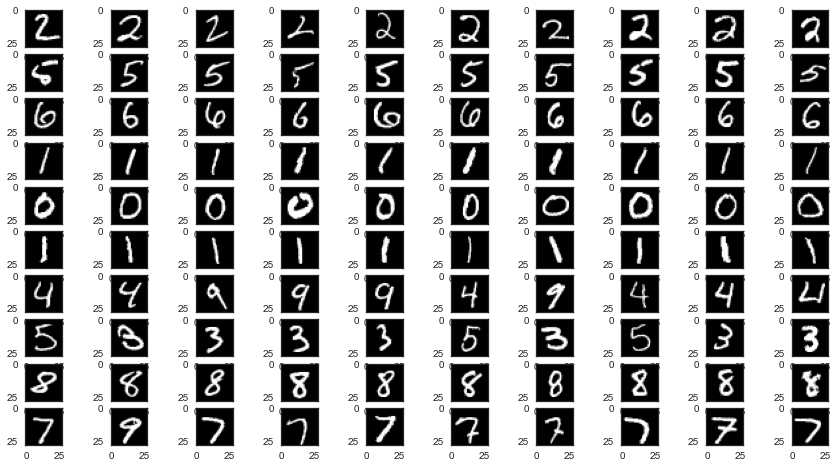

In [8]:
# Samples from each cluster
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

In [9]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc = accuracy_score(y_test, y_pred)
print(acc)

class_equivalence:  [2. 5. 6. 1. 0. 1. 4. 3. 8. 7.]
0.8206


## I.2 Latent_dim = 32

In [10]:
latent_dim = 32
autoencoder_vae_32=VAE(latent_dim=32)
autoencoder_vae_32.load_state_dict(torch.load('./VAE_models/VAE_MNIST_zdim_32_epochs_15.pth'))

<All keys matched successfully>

In [11]:
z_test = autoencoder_vae_32.encode(X_test)
z_train = autoencoder_vae_32.encode(X_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

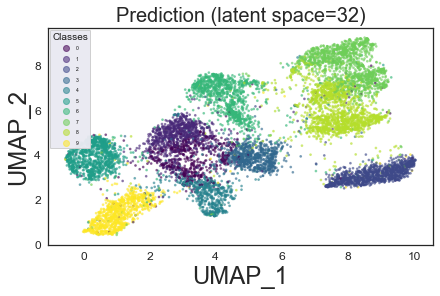

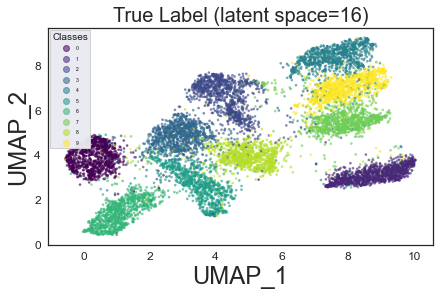

In [12]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="MNIST")

<Figure size 432x288 with 0 Axes>

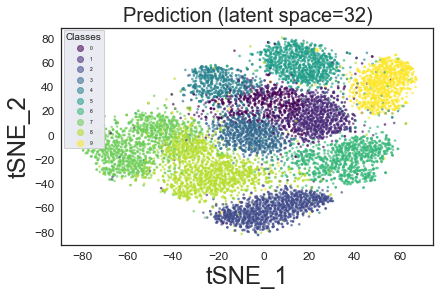

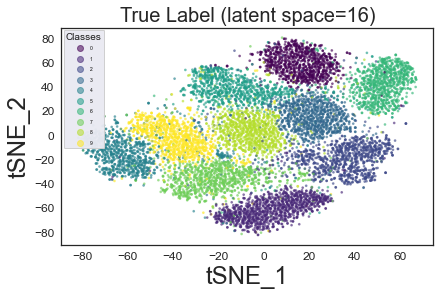

In [13]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="MNIST")

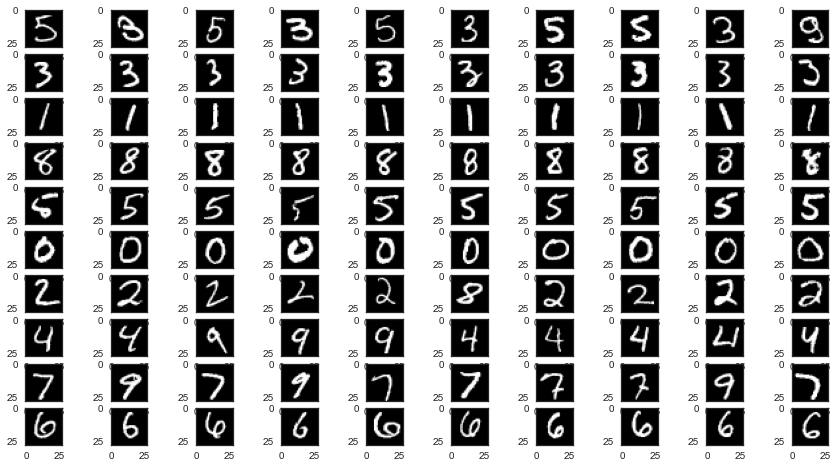

In [14]:
# Samples from each cluster
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)

plt.show()

In [15]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc = accuracy_score(y_test, y_pred)
print("accuracy = ",acc)

class_equivalence:  [5. 3. 1. 8. 5. 0. 2. 4. 7. 6.]
accuracy =  0.8157


## II. FashionMnist 

In [16]:
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST_data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


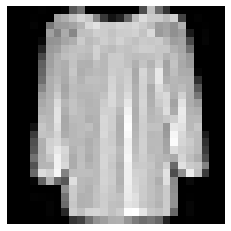

label =  tensor(6)


In [17]:
img = X_train[6][0,:,:]
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
print("label = ",Y_train[6])

## II.1 latent_dim = 16

In [18]:
latent_dim = 16
autoencoder_vae=VAE(latent_dim=16)
autoencoder_vae.load_state_dict(torch.load('./VAEFM_models/VAE_MNIST_zdim_16_epochs_15.pth'))

<All keys matched successfully>

In [19]:
z_test = autoencoder_vae.encode(X_test)
z_train = autoencoder_vae.encode(X_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

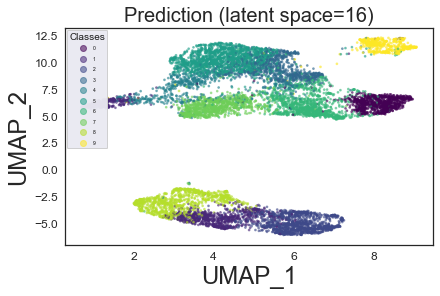

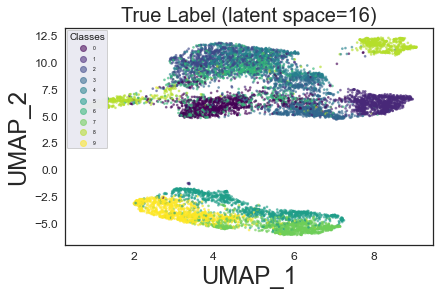

In [20]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="FashionMNIST")

<Figure size 432x288 with 0 Axes>

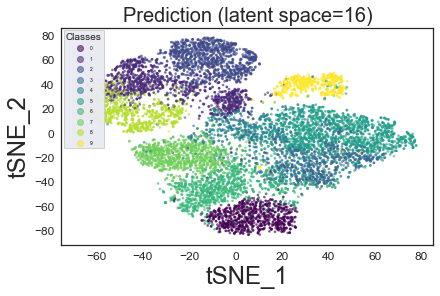

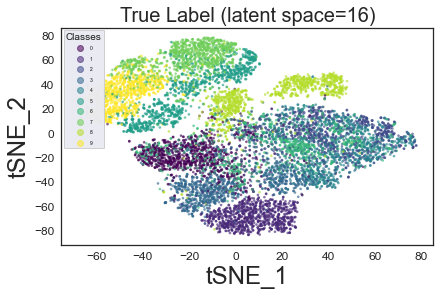

In [21]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="FashionMNIST")

In [22]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc = accuracy_score(y_test, y_pred)
print("accuracy = ",acc)

class_equivalence:  [1. 9. 7. 4. 6. 2. 3. 0. 9. 8.]
accuracy =  0.5898


## II.2 latent_dim = 32

In [23]:
latent_dim = 32
autoencoder_vae=VAE(latent_dim=32)
autoencoder_vae.load_state_dict(torch.load('./VAEFM_models/VAE_MNIST_zdim_32_epochs_15.pth'))

<All keys matched successfully>

In [24]:
z_test = autoencoder_vae.encode(X_test)
z_train = autoencoder_vae.encode(X_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

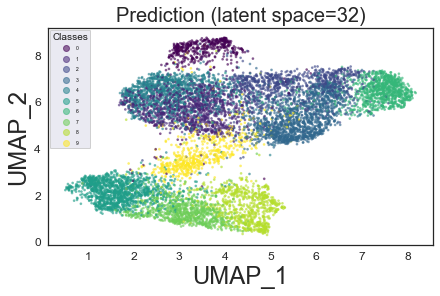

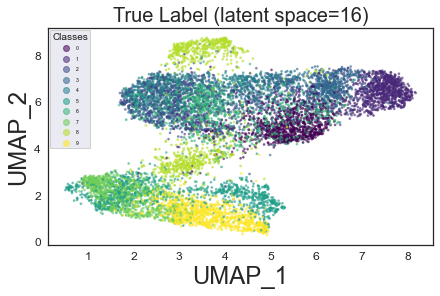

In [25]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="FashionMNIST")

<Figure size 432x288 with 0 Axes>

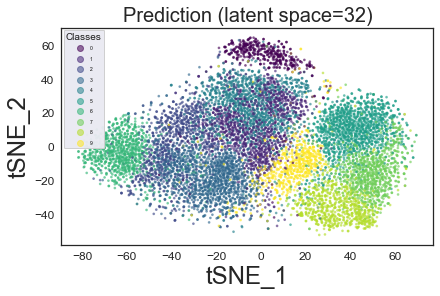

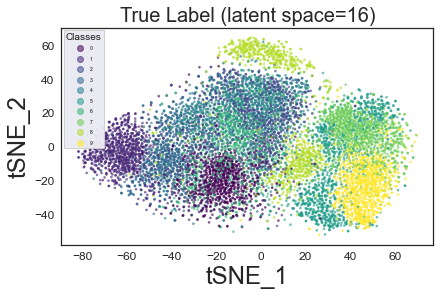

In [26]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="FashionMNIST")

In [27]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc = accuracy_score(y_test, y_pred)
print("accuracy = ",acc)

class_equivalence:  [8. 2. 3. 0. 4. 7. 1. 9. 5. 8.]
accuracy =  0.6218
